In [25]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn import preprocessing
from classifier import MaxCorrCoefClf

In [8]:
np.random.seed(777)
f_all = open('data/all_cells.p', 'rb')
all_cells = pickle.load(f_all)

In [9]:
vs_cells = [cell for cell in all_cells if cell.p_vs <= 0.05]
ms_cells = [cell for cell in all_cells if cell.p_ms <= 0.05]

In [10]:
print(len(vs_cells))
print(len(ms_cells))

292
135


In [40]:
def decoding_trial_processing(cells, start, end, cell_type):
    x = np.empty((100, 0))
    for cell in cells:
        trials = cell.trials
        if cell_type == 'visual':
            trials.sort(key = lambda trial: trial.category)
        elif cell_type == 'memory':
            trials.sort(key = lambda trial: trial.response_recog)
        cell_spike_rates = []
        for trial in trials:
            spike_rate = trial.win_spike_rate(start, end)
            cell_spike_rates.append(spike_rate)
        cell_spike_rates = np.matrix(cell_spike_rates).T
        x = np.append(x, cell_spike_rates, axis=1)
    x_scaled = preprocessing.scale(x)
    y = np.empty((1,0))
    if cell_type == 'visual':
        for i in range(5):
            y = np.append(y, np.repeat(i+1, 20))
    elif cell_type == 'memory':
        for i in range(2):
            y = np.append(y, np.repeat(i+1, 50))

    return x_scaled, y

def get_sample_trials(x, y):
    sample_index = np.random.choice(20, 10)
    sample_trials = x[sample_index, :]
    sample_labels = y[sample_index]
    return sample_trials, sample_labels
    
def vs_decoding_model(x, y, iteration=50):
    y_pred_all = np.empty((1,0))
    y_test_all = np.empty((1,0))
    for i in range(iteration):
        for split in range(10):
            x_sampled = np.empty((0, x.shape[1]))
            y_sampled = np.empty((1, 0))
            
            for i in range(5):
                start = i*20
                end = (i+1)*20
                x_temp = x[start:end,:]
                y_temp = y[start:end]
                sample_trials, sample_labels = get_sample_trials(x_temp, y_temp)
                x_sampled = np.append(x_sampled, sample_trials, axis=0)
                y_sampled = np.append(y_sampled, sample_labels)
            
            test_indexes = np.arange(5)*10 + i
            train_indexes = np.delete(np.arange(50), test_indexes)
            
            x_train = x_sampled[train_indexes, :]
            y_train = y_sampled[train_indexes]
            x_test = x_sampled[test_indexes, :]
            y_test = y_sampled[test_indexes]
            
            clf = MaxCorrCoefClf()
            clf.fit(x_train.T, y_train)
            y_pred = clf.predict(x_test.T)
            y_pred_all = np.append(y_pred_all, y_pred)
            y_test_all = np.append(y_test_all, y_test)
    accuracy = np.mean(np.equal(y_pred_all, y_test_all))
    return accuracy

def decoding_over_time(vs_cells, bin_size, step_size, cell_type, time_range=(0, 4000)):
    start = time_range[0]
    end = start + bin_size
    plot_step = bin_size/2
    accuracies = []
    x_plot = []
    while end < time_range[1]:
        x, y = decoding_trial_processing(vs_cells, start, end, cell_type)
        accuracy = vs_decoding_model(x, y)
        accuracies.append(accuracy)
        x_plot.append(start + plot_step)
        start = start + step_size
        end = start + bin_size
    return accuracies, x_plot

def decoding_time_matrix(cells, bin_size, step_size, time_range(0, 4000)):
    start = time_range[0]
    end = start + bin_size
    


In [43]:
accuracies_vs, x_plot_vs = decoding_over_time(vs_cells, 500, 50, 'visual')
#accuracies_ms, x_plot_ms = decoding_over_time(ms_cells, 500, 50, 'memory')

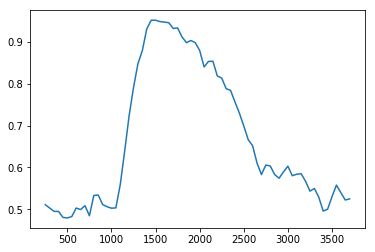

In [44]:
plt.plot(x_plot_vs, accuracies_vs)
#plt.plot(x_plot_ms, accuracies_ms)